In [1]:
import pandas as pd
import requests
import json
import gzip
import sys

from Bio import SeqIO
from enrichment_functions import * 
from draw_wordcloud import draw_word_cloud

import matplotlib.pyplot as plt

# Constants
URL = 'https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds'
PUBMED_IDS_PATH = '../../data/human_pubmed.tab.gz'
DOA_PATH = '../../data/uniprot_do.json'
DOID_PATH = '../../data/doid.obo'

## Mine and Parse DO

```Python
# { acc : disease ids list}
protein_to_do = map_protein_to_diseases(PUBMED_IDS_PATH, URL)

# Save result
json.dump(protein_to_do, '../../data/uniprot_do.json', indent = 4)

```

In [2]:
# Load DO on humans (DOA)
with open(DOA_PATH) as file:
    protein_to_do = json.load(file)

In [3]:
# Load DO ontology and parse
with open(DOID_PATH) as do_ontology:
    labels, ancestors, min_depth = parse_disease_ontology(do_ontology)

## Original dataset

In [4]:
# Read the original dataset (hits retrieved by our model)
with open("../../datasets/original.txt") as f:
    dataset = f.read().splitlines()

In [5]:
# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])

In [6]:
# count the ancestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(background, ancestors, protein_to_do)

In [7]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [8]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [9]:
result_fisher.head()

,OddRatio,p-value
6420,141.262327,1.401821e-02
0111512,141.262327,1.401821e-02
5749,141.262327,1.401821e-02
1884,101.164893,1.300295e-08
11702,94.235965,4.875143e-04


In [10]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
6420,141.262327,1.401821e-02,6,pulmonary valve stenosis
0111512,141.262327,1.401821e-02,7,metachondromatosis
5749,141.262327,1.401821e-02,5,pulmonary valve disease
1884,101.164893,1.300295e-08,6,viral hepatitis
11702,94.235965,4.875143e-04,6,dysgammaglobulinemia


In [11]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.5
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 0.001736111111111111


In [13]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 6) & (result_fisher["p-value"] <= adjusted_threshold)

result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
6420,141.262327,1.401821e-02,6,pulmonary valve stenosis
5749,141.262327,1.401821e-02,5,pulmonary valve disease
1884,101.164893,1.300295e-08,6,viral hepatitis
11702,94.235965,4.875143e-04,6,dysgammaglobulinemia
6025,94.235965,4.875143e-04,5,selective immunoglobulin deficiency disease


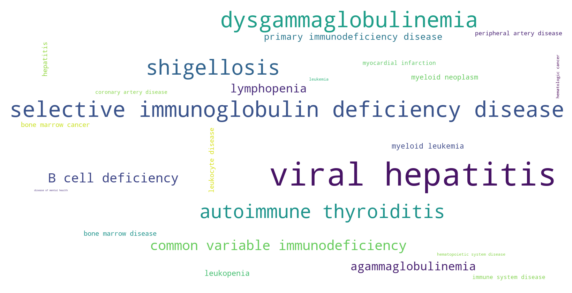

In [13]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = N,
    score = 'OddRatio',
    under_represented = False
)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()